# Visualizing and Analysing Neighborhoods in Torronto
Also, the maps i created are not visible in github, so i have save a html file of the maps created in this notebook

Importing Necessary Libraries

In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
from bs4 import BeautifulSoup
print('Libraries imported.')

Libraries imported.


Getting DataFrame:

In [2]:
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
res = requests.get(url)

soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]

df=df[df['Borough']!='Not assigned']

for row in df.values:
    row[2]=row[2].replace("/",",")

df.reset_index(drop=True,inplace=True)

df.head(2)

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village


Getting the Coordinates for the areas using Geospatial_data.csv

In [3]:
geo_data=pd.read_csv("https://cocl.us/Geospatial_data")
geo_data.set_index('Postal Code',inplace=True)

geo_data.head(2)

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497


Adding respective coordinates to the Postal Code DataFrame

In [4]:
add_df={"Latitude":[],'Longitude':[]}
for  pcode in df['Postal code']:
    for key in add_df.keys():
        add_df[key].append(geo_data.loc[pcode][key])
neigh_df=pd.concat((df,pd.DataFrame(add_df)),axis=1)

neigh_df.head(3)

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636


Diferent Neighborhoods in CANADA

In [5]:
neigh_df['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [6]:
address= "Toronto, TO"
geolocator = Nominatim(user_agent="to_explorer")
loc=geolocator.geocode(address)
lat=loc.latitude
lon=loc.longitude
print("Coordinates of Toronto are: Latitude:",lat,"Longitude: ",lon)

Coordinates of Toronto are: Latitude: 43.6534817 Longitude:  -79.3839347


Locating all the neighborhoods in Toronto on Map

In [63]:
map_canada = folium.Map(location=[lat,lon],zoom_start=10)
#Area Makers
for n_lat,n_lng,borough,neigh in zip(neigh_df['Latitude'],
                                     neigh_df['Longitude'],
                                    neigh_df['Borough'],
                                     neigh_df['Neighborhood']):
    label='{}, {}'.format(neigh, borough)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker([n_lat,n_lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_canada)


map_canada

In [8]:
#Foursquare API Credentials:
CLIENT_ID = 'XXXX' #Foursquare ID
CLIENT_SECRET = 'XXXX' #Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [9]:
test_neigh,test_lat,test_lng=neigh_df.values[2][2:]
LIMIT=100
radius=500
url=url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    test_lat,
    test_lng,
    radius, 
    LIMIT)
print("Test at location:",test_neigh)

Test at location: Regent Park , Harbourfront


In [10]:
#Request data from Foursquare API
results=requests.get(url).json()

#Now we are ready to clean the json and structure it into a *pandas* dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues.head(3)

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-54ea41ad498e9a11e9e13308-0,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",54ea41ad498e9a11e9e13308,362 King St E,CA,Toronto,Canada,Trinity St,143,"[362 King St E (Trinity St), Toronto ON M5A 1K...","[{'label': 'display', 'lat': 43.65344672305267...",43.653447,-79.362017,NaN,M5A 1K9,ON,Roselle Desserts,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-53b8466a498e83df908c3f21-1,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",53b8466a498e83df908c3f21,368 King St E,CA,Toronto,Canada,at Trinity St,122,"[368 King St E (at Trinity St), Toronto ON, Ca...","[{'label': 'display', 'lat': 43.65355870959944...",43.653559,-79.361809,NaN,NaN,ON,Tandem Coffee,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ae5b91ff964a520a6a121e3-2,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",4ae5b91ff964a520a6a121e3,457 King St. E,CA,Toronto,Canada,Gilead Place,54,"[457 King St. E (Gilead Place), Toronto ON M5A...","[{'label': 'display', 'lat': 43.65394694263529...",43.653947,-79.361149,NaN,M5A 1L6,ON,Morning Glory Cafe,0,[],39686393


Since the data extracted is not clean, we have to clean it for usage

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149
3,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
4,Body Blitz Spa East,Spa,43.654735,-79.359874


In [13]:
print("Total Venues returned:",len(nearby_venues))

Total Venues returned: 48


Now that the dataframe is cleaned, we can now run the Foursquare API and create a dataset

In [21]:
LIMIT=100
radius=500
venues_all={'Neighborhood':[], 'Neighborhood Latitude':[], 'Neighborhood Longitude':[],
       'Venue':[], 'Venue Latitude':[], 'Venue Longitude':[], 'Venue Category':[]}
for n_name,n_lat,n_lng in neigh_df.values[:,2:]:
    url=url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    n_lat,
    n_lng,
    radius, 
    LIMIT)
    try:
        results=requests.get(url).json()['response']['groups'][0]['items']
    except:
        results=requests.get(url).json()    
    for row in results:
        keys=list(venues_all.keys())
        venues_all[keys[0]].append(n_name)
        venues_all[keys[1]].append(n_lat)
        venues_all[keys[2]].append(n_lng)
        venues_all[keys[3]].append(row['venue']['name'])
        venues_all[keys[4]].append(row['venue']['location']['lat'])
        venues_all[keys[5]].append(row['venue']['location']['lng'])
        venues_all[keys[6]].append(row['venue']['categories'][0]['name'])
    print(n_name)

Parkwoods
Victoria Village
Regent Park , Harbourfront
Lawrence Manor , Lawrence Heights
Queen's Park , Ontario Provincial Government
Islington Avenue
Malvern , Rouge
Don Mills
Parkview Hill , Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park , Princess Gardens , Martin Grove , Islington , Cloverdale
Rouge Hill , Port Union , Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate , Bloordale Gardens , Old Burnhamthorpe , Markland Wood
Guildwood , Morningside , West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor , Wilson Heights , Downsview North
Thorncliffe Park
Richmond , Adelaide , King
Dufferin , Dovercourt Village
Scarborough Village
Fairview , Henry Farm , Oriole
Northwood Park , York University
East Toronto
Harbourfront East , Union Station , Toronto Islands
Little Portugal , Trinity
Kennedy Park , Ionview , East Birchmount Park
Bayview Village
Do

Names of all the areas for which data is exctracted from Foursquare's Database

In [15]:
toronto_venues=pd.DataFrame(venues_all)

toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


We have exctracted all the necessary data and converted into a usable DataFrame having 2147 rows

In [22]:
toronto_venues.shape

(2147, 7)

Visualizing number of venues in Torronto

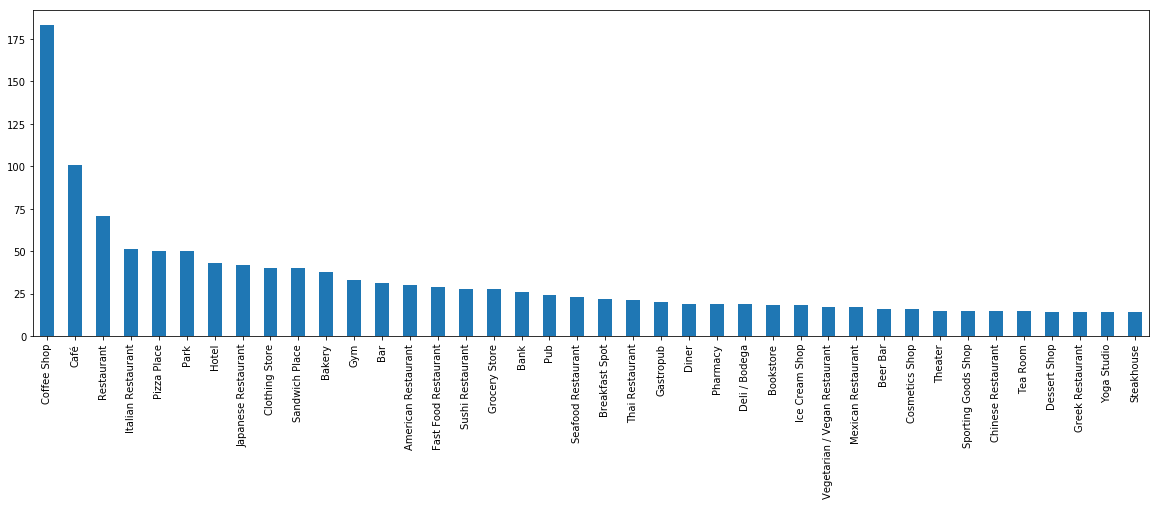

In [58]:
toronto_venues['Venue Category'].value_counts()[:40].plot.bar(figsize=(20,6))

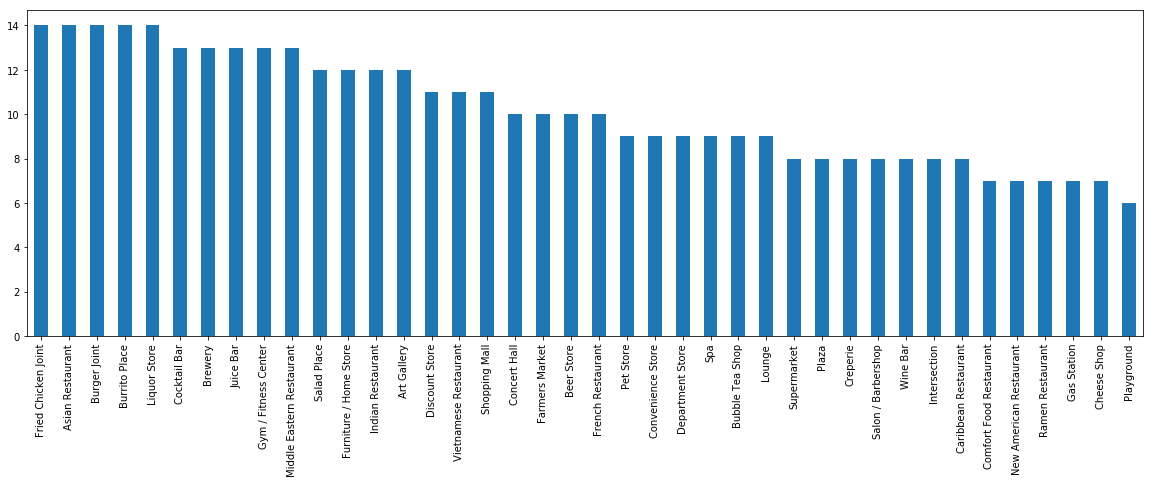

In [48]:
toronto_venues['Venue Category'].value_counts()[40:80].plot.bar(figsize=(20,6))

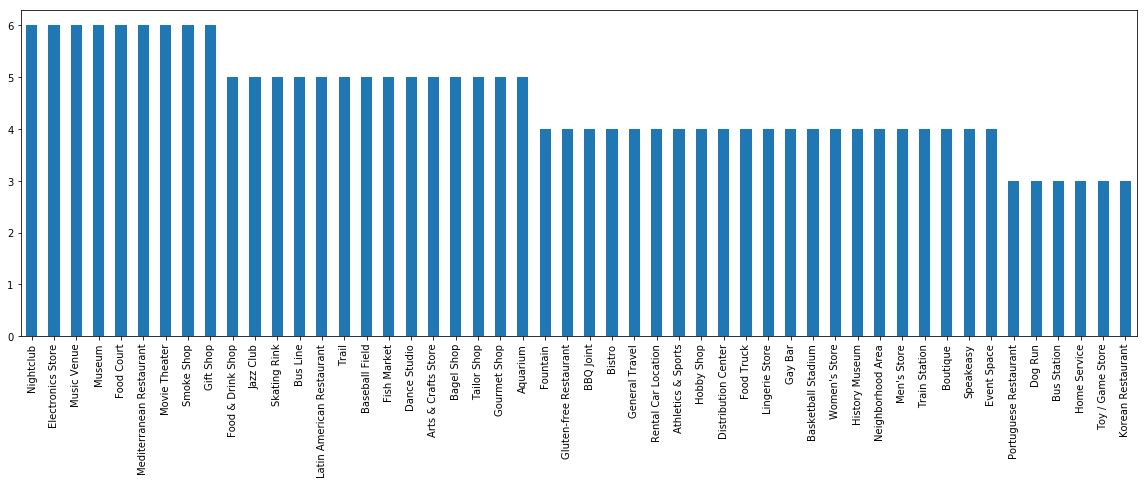

In [49]:
toronto_venues['Venue Category'].value_counts()[80:130].plot.bar(figsize=(20,6))

It was found that some places were categorized as "Neighborhood", so renaming the category to "Neighborhood Area"

In [23]:
ind_list=toronto_venues[toronto_venues["Venue Category"]=="Neighborhood"]["Venue Category"].index

toronto_venues.loc[ind_list,"Venue Category"]="Neighborhood Area"

In [24]:
toronto_venues.groupby("Neighborhood").count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood , Long Branch",10,10,10,10,10,10
"Bathurst Manor , Wilson Heights , Downsview North",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park , Lawrence Manor East",23,23,23,23,23,23


Now, Converting all the categories into dummies for Analysis

In [25]:
toronto_cat=pd.get_dummies(toronto_venues['Venue Category'])
add_neigh=pd.DataFrame({'Neighborhood':toronto_venues['Neighborhood']})
toronto_cat=pd.concat((add_neigh,toronto_cat),axis=1)
toronto_cat.head()

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood Area,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

We have stored Categories of each area in a DataFrame, for further analysis we have to group the data with respect to their areas, for analysis we will store the mean of each category present in an area.

In [26]:
toronto_grouped=toronto_cat.groupby("Neighborhood").mean().reset_index()

toronto_grouped.head()

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood Area,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.

Now we can rank the categories in each area.

In [27]:
rank_neigh={}
for row_num in range(len(toronto_grouped)):
    rank_neigh[toronto_grouped.iloc[row_num,0]]=list(toronto_grouped.iloc[row_num,1:].sort_values(ascending=False)[:10].index) 
col=['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']
neigh_venues_sorted=pd.DataFrame.from_dict(rank_neigh,orient='index',columns=col).reset_index().rename(columns={'index':'Neighborhood'})

neigh_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Breakfast Spot,Lounge,Chinese Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,"Alderwood , Long Branch",Pizza Place,Coffee Shop,Pharmacy,Sandwich Place,Dance Studio,Pub,Athletics & Sports,Skating Rink,Gym,Comic Shop
2,"Bathurst Manor , Wilson Heights , Downsview North",Coffee Shop,Bank,Pharmacy,Shopping Mall,Sandwich Place,Bridal Shop,Diner,Restaurant,Ice Cream Shop,Deli / Bodega
3,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Yoga Studio
4,"Bedford Park , Lawrence Manor East",Sandwich Place,Coffee Shop,Italian Restaurant,Restaurant,Pizza Place,Sushi Restaurant,Thai Restaurant,Liquor Store,Indian Restaurant,Pub


Now that we have numeric data and top 10 category of venues in each neighborhood we can now perform K-Means Clustering, by creating 6 Clusters

In [50]:
#setting number of clusters
k_clusters=6
neigh_clusters = toronto_grouped.drop('Neighborhood',axis=1)

kmeans=KMeans(n_clusters=k_clusters, random_state=0).fit(neigh_clusters)

kmeans.labels_[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Now Labeling the Cluster number to each area:

In [51]:
neigh_venues_sorted.insert(0,'Cluster Labels',kmeans.labels_)

toronto_merged = neigh_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neigh_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.dropna(axis=0,inplace=True)

toronto_merged.head() # check the last columns!

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3.0,Park,Bus Stop,Food & Drink Shop,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store,Electronics Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Coffee Shop,Grocery Store,Hockey Arena,Portuguese Restaurant,Yoga Studio,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Pub,Park,Bakery,Theater,Restaurant,Café,Breakfast Spot,Hotel,Beer Store
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Furniture / Home Store,Accessories Store,Vietnamese Restaurant,Carpet Store,Miscellaneous Shop,Event Space,Coffee Shop,Boutique,Drugstore
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Diner,Juice Bar,Bank,Bar,Café,Spa,Beer Bar,Yoga Studio


Visualizing the Clusters on a Map

In [62]:
map_clusters = folium.Map(location=[lat,lon], zoom_start=10)

x=np.arange(k_clusters)
ys= [i + x + (i*x)**2 for i in range(k_clusters)]
colors_arr=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow= [colors.rgb2hex(i) for i in colors_arr]

makers_clr = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'],
                                toronto_merged['Longitude'],
                                toronto_merged['Neighborhood'],
                                toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster '+str(cluster),parse_html=True)
    folium.CircleMarker(
    [lat,lon],
    radius=5,
    popup=label,
    color=rainbow[int(cluster)-1],
    fill=True,
    fill_color=rainbow[int(cluster)-1],
    fill_opacity=0.7).add_to(map_clusters)

map_clusters

DataFrames for different areas in a cluster

## Cluster 1

In [57]:
toronto_merged[toronto_merged['Cluster Labels']==0.0].iloc[:,[2]+list(range(6,16))]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Coffee Shop,Grocery Store,Hockey Arena,Portuguese Restaurant,Yoga Studio,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
2,"Regent Park , Harbourfront",Coffee Shop,Pub,Park,Bakery,Theater,Restaurant,Café,Breakfast Spot,Hotel,Beer Store
3,"Lawrence Manor , Lawrence Heights",Clothing Store,Furniture / Home Store,Accessories Store,Vietnamese Restaurant,Carpet Store,Miscellaneous Shop,Event Space,Coffee Shop,Boutique,Drugstore
4,"Queen's Park , Ontario Provincial Government",Coffee Shop,Sushi Restaurant,Diner,Juice Bar,Bank,Bar,Café,Spa,Beer Bar,Yoga Studio
6,"Malvern , Rouge",Fast Food Restaurant,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
7,Don Mills,Japanese Restaurant,Beer Store,Coffee Shop,Gym,Restaurant,Asian Restaurant,Italian Restaurant,Caribbean Restaurant,Sandwich Place,Bike Shop
8,"Parkview Hill , Woodbine Gardens",Pizza Place,Pharmacy,Fast Food Restaurant,Café,Breakfast Spot,Athletics & Sports,Intersection,Pet Store,Bank,Gym / Fitness Center
9,"Garden District, Ryerson",Clothing Store,Coffee Shop,Café,Cosmetics Shop,Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Japanese Restaurant,Tea Room,Diner
10,Glencairn,Pizza Place,Pub,Japanese Restaurant,Yoga Studio,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
12,"Rouge Hill , Port Union , Highland Creek",Bar,History Museum,Yoga Studio,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center,Dance Studio


## Cluster 2

In [467]:
toronto_merged[toronto_merged['Cluster Labels']==1.0].iloc[:,[2]+list(range(6,16))]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Regent Park , Harbourfront",Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Cosmetics Shop,Shoe Store,Restaurant
3,"Lawrence Manor , Lawrence Heights",Furniture / Home Store,Clothing Store,Coffee Shop,Event Space,Shoe Store,Miscellaneous Shop,Accessories Store,Boutique,Women's Store,Vietnamese Restaurant
7,Don Mills,Asian Restaurant,Restaurant,Beer Store,Coffee Shop,Japanese Restaurant,Gym,Concert Hall,Shopping Mall,Supermarket,Caribbean Restaurant
9,"Garden District, Ryerson",Clothing Store,Coffee Shop,Café,Middle Eastern Restaurant,Cosmetics Shop,Restaurant,Japanese Restaurant,Bubble Tea Shop,Bookstore,Fast Food Restaurant
12,"Rouge Hill , Port Union , Highland Creek",Bar,History Museum,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
13,Don Mills,Asian Restaurant,Restaurant,Beer Store,Coffee Shop,Japanese Restaurant,Gym,Concert Hall,Shopping Mall,Supermarket,Caribbean Restaurant
14,Woodbine Heights,Skating Rink,Athletics & Sports,Park,Pharmacy,Video Store,Cosmetics Shop,Spa,Curling Ice,Beer Store,Asian Restaurant
15,St. James Town,Coffee Shop,Café,Gastropub,American Restaurant,Cocktail Bar,Italian Restaurant,Farmers Market,Hotel,Cosmetics Shop,Moroccan Restaurant
16,Humewood-Cedarvale,Field,Dog Run,Trail,Hockey Arena,Drugstore,Discount Store,Distribution Center,Doner Restaurant,Donut Shop,Yoga Studio
17,"Eringate , Bloordale Gardens , Old Burnhamthor...",Pet Store,Convenience Store,Pizza Place,Liquor Store,Cosmetics Shop,Café,Beer Store,Coffee Shop,Yoga Studio,Dumpling Restaurant


## Cluster 3

In [468]:
toronto_merged[toronto_merged['Cluster Labels']==2.0].iloc[:,[2]+list(range(6,16))]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Malvern , Rouge",Fast Food Restaurant,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


## Cluster 4

In [469]:
toronto_merged[toronto_merged['Cluster Labels']==3.0].iloc[:,[2]+list(range(6,16))]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Food & Drink Shop,Park,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio
21,Caledonia-Fairbanks,Park,Women's Store,Pool,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
35,East Toronto,Intersection,Park,Convenience Store,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
49,"North Park , Maple Leaf Park , Upwood Park",Construction & Landscaping,Park,Bakery,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
66,York Mills West,Park,Convenience Store,Bank,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
83,"Moore Park , Summerhill East",Park,Playground,Trail,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
91,Rosedale,Park,Playground,Trail,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
98,"The Kingsway , Montgomery Road , Old Mill North",Park,Pool,River,Construction & Landscaping,Dim Sum Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


## Cluster 5

In [470]:
toronto_merged[toronto_merged['Cluster Labels']==4.0].iloc[:,[2]+list(range(6,16))]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
101,"Old Mill South , King's Mill Park , Sunnylea ,...",Baseball Field,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Filipino Restaurant


## Cluster 6

In [471]:
toronto_merged[toronto_merged['Cluster Labels']==5.0].iloc[:,[2]+list(range(6,16))]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Hockey Arena,Portuguese Restaurant,French Restaurant,Coffee Shop,Intersection,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Diner
4,"Queen's Park , Ontario Provincial Government",Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,Burrito Place,Bar,Beer Bar,Spa,Italian Restaurant,Japanese Restaurant
22,Woburn,Coffee Shop,Korean Restaurant,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
24,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Salad Place,Bubble Tea Shop,Ice Cream Shop,Fried Chicken Joint,Yoga Studio
34,"Northwood Park , York University",Coffee Shop,Massage Studio,Bar,Caribbean Restaurant,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
38,"Kennedy Park , Ionview , East Birchmount Park",Coffee Shop,Department Store,Bus Station,Hobby Shop,Discount Store,Train Station,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop
56,"Del Ray , Mount Dennis , Keelsdale and Silvert...",Restaurant,Sandwich Place,Bar,Coffee Shop,Convenience Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
76,Canada Post Gateway Processing Centre,Hotel,Coffee Shop,Intersection,Middle Eastern Restaurant,Gym,Mediterranean Restaurant,American Restaurant,Burrito Place,Fried Chicken Joint,Sandwich Place
85,"Milliken , Agincourt North , Steeles East , L'...",Coffee Shop,Park,Playground,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
